# Simulação de uma análise real

Independente do tipo de projeto (se for usar o jupyter ou Idle) é uma boa prática seguir algumas etapas:

1. Import de bibliotecas utilizadas
2. Definir funções que serão utilizadas
3. Analisar os dados (ou realizar testes em um projeto de automatização)
4. Propor a solução

Aqui utilizaremos o problema da demanda de bicicletas: https://www.kaggle.com/c/bike-sharing-demand/overview

# 1 - Importando bibliotecas

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

base = pd.read_csv('bike.csv')

# 2 - Definindo funções utilizadas

Essa parte é organizacional, no fim você organiza elas, na prática você vai ir fazendo as funções conforme for precisando

In [106]:
# Função que imprime valores, maximos, minimos, medios e a mediana da variavel
def descreve_variavel(base,var):
    print("Descrição da variavel ", var, '\n\n')
    
    media = base[var].mean()
    maior = base[var].max()
    menor = base[var].min()
    mediana = base[var].median()
    
    print(f" Media: {media} \n Maior valor: {maior} \n Menor valor: {menor} \n Mediana: {mediana} \n")
    print("_____________________________________________________________________")

In [107]:
# Função que retorna 1 para valores maiores que "valor" e 0 para menores ou iguais

def divisor(x, valor):
    return x > valor

# 3 - Analisando os dados

In [108]:
# Visualizando nossa base de dados
base.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### 3.1 - Checando consistencia de dados

In [109]:
# Vamos checar se existem valores missings ou nulos em alguma coluna
base.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

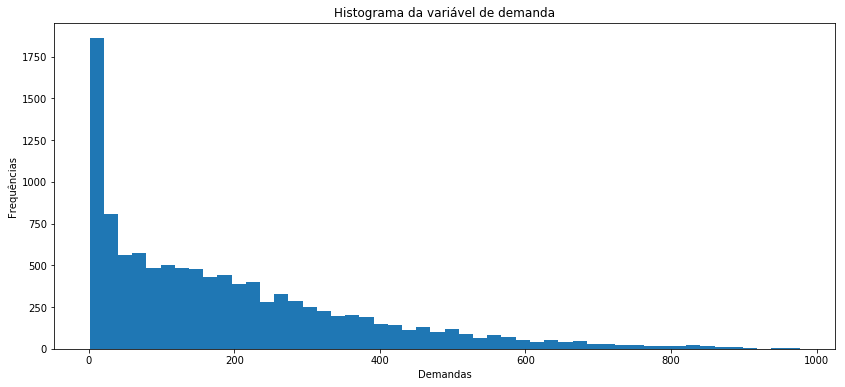

In [110]:
# Será que existem números absurdos na variável resposta

# Utilizando a função de histograma da aula 3

plt.figure(figsize=(14,6))
plt.title("Histograma da variável de demanda")

# Dessa vez utilizamos a função "dropna" do pandas para limpar dados nulos da série de dados de idades
plt.hist(base['count'].dropna() ,bins=50)
plt.xlabel('Demandas')
plt.ylabel('Frequências')
plt.show()

In [111]:
# Checando consistências das variáveis 
descreve_variavel(base,'humidity')
descreve_variavel(base,'temp')
descreve_variavel(base,'windspeed')

Descrição da variavel  humidity 


 Media: 61.88645967297446 
 Maior valor: 100 
 Menor valor: 0 
 Mediana: 62.0 

_____________________________________________________________________
Descrição da variavel  temp 


 Media: 20.23085981995223 
 Maior valor: 41.0 
 Menor valor: 0.82 
 Mediana: 20.5 

_____________________________________________________________________
Descrição da variavel  windspeed 


 Media: 12.7993954069447 
 Maior valor: 56.9969 
 Menor valor: 0.0 
 Mediana: 12.998 

_____________________________________________________________________


Aparentemente os dados são bem comportados, nenhuma anomalia aparente então podemos começar a analisar os dados

### 3.2 - Analisando relações

In [112]:
# Será que existe alguma relação entre a hora e as demandas? Faz sentido....

# Extraindo informações da variável datetime
info_tempo = pd.DatetimeIndex(base.datetime)
# A partir da extração de dados conseguimos extrair informações específicas como Hora, Dia, mes e etc...
base['hora'] = info_tempo.hour
base['dia'] = info_tempo.day
base['ano'] = info_tempo.year
base['mes'] = info_tempo.month

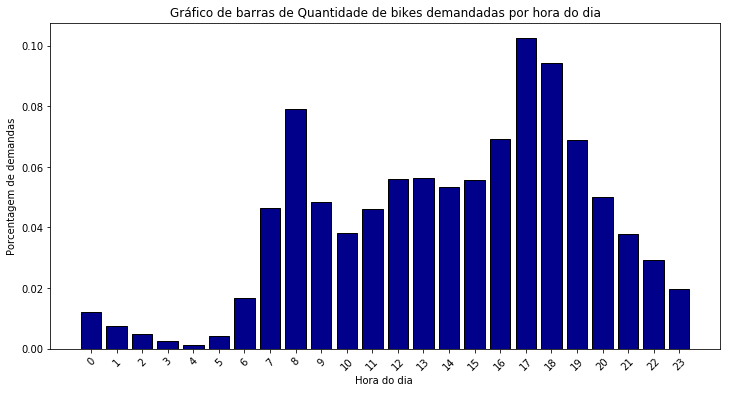

In [113]:
# Utilizando a função de barplot da aula3

# Agrupando a base pela variável de hora e calculando a soma de demandas para cada hora
analise0 = base.groupby('hora').agg({'count':np.sum}).reset_index()
analise0['count'] = analise0['count']/analise0['count'].sum()

plt.figure(figsize=(12,6))

plt.title("Gráfico de barras de Quantidade de bikes demandadas por hora do dia")

plt.bar(np.arange(analise0.shape[0]),analise0['count'], color='darkblue', edgecolor = 'black')

plt.xticks(np.arange(analise0.shape[0]), analise0.hora,rotation = 45)

plt.xlabel("Hora do dia ")
plt.ylabel("Porcentagem de demandas")

plt.show()

In [114]:
analise0

,hora,count
0,0,0.012030
1,1,0.007371
2,2,0.004919
3,3,0.002441
4,4,0.001358
5,5,0.004284
6,6,0.016638
7,7,0.046497
8,8,0.079147
9,9,0.048387


Aparentemente no começo da manhã (8% de ocorrência as 8 da manha) e final da tarde (10% de ocorrência as 17 horas) ocorrem os picos de pedidos

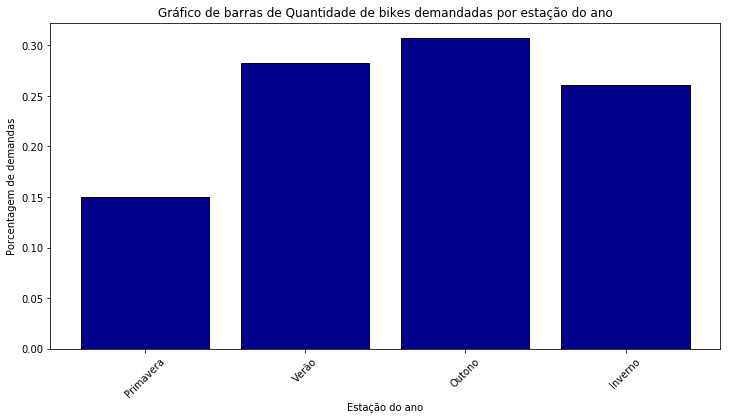

In [115]:
# Será que a quantidade de bicicletas usadas depende da estação do ano?

# Agrupando a base pela variável de estação do ano e calculando a soma de demandas para cada estação
analise1 = base.groupby('season').agg({'count':np.sum}).reset_index()
analise1['count'] = analise1['count']/analise1['count'].sum()

estacoes = ['Primavera','Verão','Outono','Inverno']


# Utilizando a função de barplot da aula3

plt.figure(figsize=(12,6))

plt.title("Gráfico de barras de Quantidade de bikes demandadas por estação do ano")

plt.bar(np.arange(analise1.shape[0]),analise1['count'], color='darkblue', edgecolor = 'black')

plt.xticks(np.arange(analise1.shape[0]), estacoes,rotation = 45)

plt.xlabel("Estação do ano")
plt.ylabel("Porcentagem de demandas")

plt.show()

In [116]:
analise1

,season,count
0,1,0.149845
1,2,0.282085
2,3,0.307202
3,4,0.260868


Por algum motivo as demandas na primavera (ocorrência de 15%) são menores que em outras estações (ocorrência média de 28%)

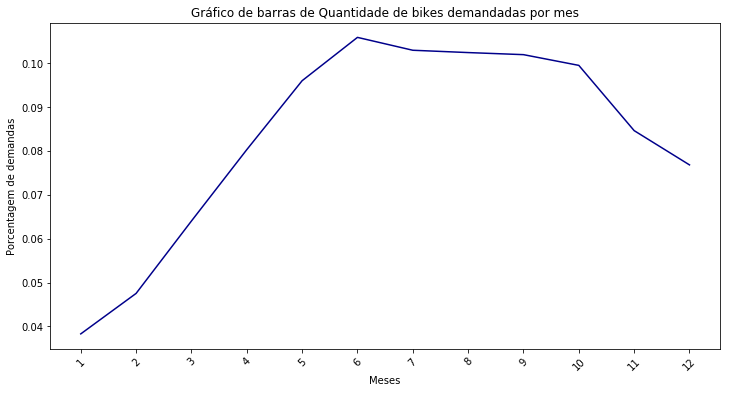

In [117]:
# É possível ver uma detalhamento maior desse efeito olhando por mes?

# Agrupando a base pela variável de mes e calculando a soma de demandas para cada mes
analise2 = base.groupby('mes').agg({'count':np.sum}).reset_index()
analise2['count'] = analise2['count']/analise2['count'].sum()

plt.figure(figsize=(12,6))

plt.title("Gráfico de barras de Quantidade de bikes demandadas por mes")

plt.plot(np.arange(analise2.shape[0]),analise2['count'], color='darkblue')

plt.xticks(np.arange(analise2.shape[0]), analise2.mes,rotation = 45)

plt.xlabel("Meses")
plt.ylabel("Porcentagem de demandas")

plt.show()

In [118]:
analise2

,mes,count
0,1,0.038305
1,2,0.047525
2,3,0.064015
3,4,0.080270
4,5,0.095972
5,6,0.105843
6,7,0.102910
7,8,0.102382
8,9,0.101909
9,10,0.099466


Aparentemente há um pico a partir do mês de junho

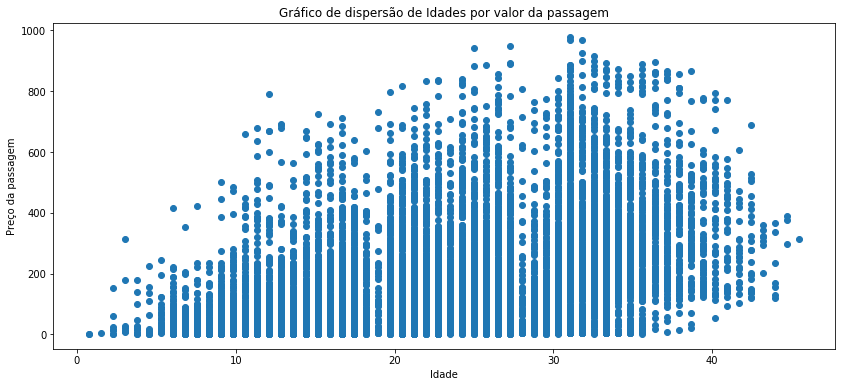

In [119]:
# Existe uma relação entre a temperatura do ar e a demanda por bicicletas?

plt.figure(figsize=(14,6))
plt.title("Gráfico de dispersão de Idades por valor da passagem")
plt.scatter(data=base,x='atemp',y='count')
plt.xlabel("Idade")
plt.ylabel("Preço da passagem")
plt.show()

Aparentemente existe uma relação entre temperatura do ar com a demanda

# Propondo uma solução

In [120]:
base.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hora,dia,ano,mes
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,2011,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,2011,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,2011,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,2011,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,2011,1


In [121]:
# Criando variáveis a partir de analises da seção 3

base['hora_cortada'] = divisor(base.hora, 7)
base['estacao_cortada'] = divisor(base.season, 1)
base['mes_cortada'] = divisor(base.mes, 5)

In [122]:
# Definindo variáveis que queremos utilizar na previsão
variaveis = ['hora_cortada','estacao_cortada','mes_cortada','atemp','humidity','holiday','workingday','weather']

# Definindo a base de dados e a resposta
X = base[variaveis]
y = base['count']

# Dividindo a base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [123]:
minha_regressao = LinearRegression()
minha_regressao.fit(X_train,y_train)
minha_regressao.score(X_test, y_test)

0.39900672213400035

# Exemplo de previsão

In [131]:
# Duas observações, quantas demandas tiveram nesses dois dias?
X_test[variaveis].iloc[2:4]

,hora_cortada,estacao_cortada,mes_cortada,atemp,humidity,holiday,workingday,weather
5224,True,True,True,11.365,48,0,0,1
8953,True,True,True,34.090,62,0,1,2


In [129]:
# Pelo modelo
minha_regressao.predict(X_test[variaveis].iloc[2:4])

array([ 234.01456933,  306.856202  ])

In [130]:
# Resposta verdadeira
y_test.iloc[2:4]

5224    163
8953    233
Name: count, dtype: int64

Existe uma linearidade na predição mas com valores um pouco longe, ou seja, é necessário alinhar o quão assertivo você quer as predições e melhorar o modelo.